# Load Data

In [1]:
import pandas as pd
import numpy as np
import re

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import mplcyberpunk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
%matplotlib inline

import warnings
warnings.simplefilter('ignore', DeprecationWarning)


In [2]:
papers = pd.read_csv('archive/papers.csv')
papers.head(4)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...


# Data Preparation

### Drop Columns have no useful text info

In [3]:
papers.drop(['id', 'event_type', 'pdf_name'], axis=1, inplace=True)
papers.head(4)

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...


# Visualize Publication with time

In [4]:
#plt.style.use('cyberpunk')
#paper_counts = sns.countplot(papers.year)
#plt.xticks(rotation=90)
#mplcyberpunk.add_glow_effects()

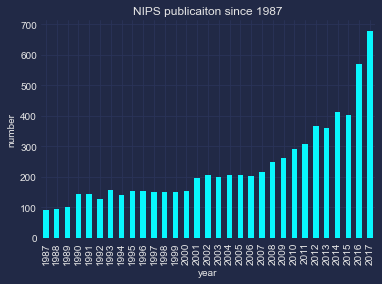

In [5]:
publication_counts = papers.groupby('year').size()

plt.style.use('cyberpunk')
publication_counts.plot(kind='bar')
plt.title('NIPS publicaiton since 1987')
plt.xlabel('year')
plt.ylabel('number')
mplcyberpunk.add_glow_effects()

# Text Data Processing

In [6]:
%%time
papers['title_processed'] = papers.title.map(lambda x: re.sub('[,\.!?]', '', x))

CPU times: user 12.1 ms, sys: 579 µs, total: 12.7 ms
Wall time: 12.3 ms


In [7]:
%%time
papers['title_processed'] = papers.title_processed.map(lambda x: re.sub(r'\d+', '', x))

CPU times: user 20.2 ms, sys: 510 µs, total: 20.7 ms
Wall time: 20.3 ms


In [8]:
%%time
papers['title_processed'] = papers.title_processed.map(lambda x: x.lower())
print(papers['title_processed'][0][:500])

self-organization of associative database and its applications
CPU times: user 3.01 ms, sys: 266 µs, total: 3.27 ms
Wall time: 3.2 ms


In [9]:
#%%time
# Tokenize
#papers['title_processed']= papers.title_processed.map(lambda x: RegexpTokenizer(r'\w+').tokenize(x))
#print(papers['title_processed'][0][:25])

In [10]:
#%%time
#stop_words = stopwords.words('english')
#papers['title_processed']  = papers.title_processed.map(lambda x: [t for t in x if t not in stop_words])
#print(papers['title_processed'][0][:25])

In [11]:
#%%time
#papers['title_processed'] = papers.title_processed.map(lambda x: [t for t in x if len(t) > 1])

# WordCloud Visualization

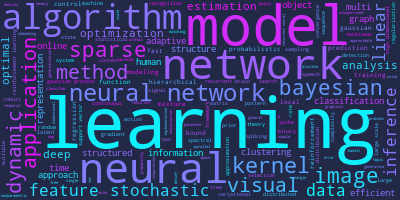

In [22]:
# Join the different processed text together
paper_string = ''.join(papers.title_processed)

stop_words = set(STOPWORDS)
stop_words.add('via')
stop_words.add('using')
stop_words.add('based')

NipsCloud = WordCloud(stopwords=stop_words, colormap='cool', background_color='#212946')
NipsCloud.generate(paper_string)
plt.style.use('cyberpunk')
NipsCloud.to_file('WordCloud.eps')
NipsCloud.to_image()

# Top-10 Most Frequent word

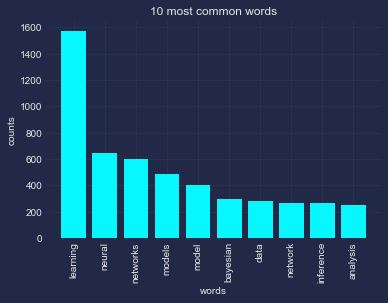

In [39]:
def plot_top_10(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    
    count_dict = sorted(count_dict, key = lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x = np.arange(len(words))
    
    plt.bar(x, counts, align='center')
    plt.xticks(x, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.savefig('10_most_common_words.png')
    plt.show()
    
# Initialize the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=list(stop_words))
count_data = count_vectorizer.fit_transform(papers['title_processed'])
plot_top_10(count_data, count_vectorizer)

# LDA

In [53]:
def print_topics(model, count_ectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for i, topic in enumerate(model.components_):
        print('\nThe {}-th topic is'.format(i))
        print(''.join([words[t] for t in topic.argsort()[:-n_top_words-1:-1]]))

num_topics = 10
num_words = 6

lda = LDA(n_components=num_topics)
lda.fit(count_data)

print('Topics found by LDA')
print_topics(lda, count_vectorizer, num_words)

Topics found by LDA

The 0-th topic is
learningbanditsneuralfunctionsvisualattention

The 1-th topic is
learningsparseoptimalhighclusteringdimensional

The 2-th topic is
networksneurallearningdeeplargerecurrent

The 3-th topic is
datarecognitionobjectspeechvectorsupport

The 4-th topic is
learningoptimizationstochasticgradientalgorithmsonline

The 5-th topic is
neuraltimenetworksinformationneuronssystems

The 6-th topic is
modelsinferencelearningmarkovvariationalmodel

The 7-th topic is
gaussianregressionprocessanalysisprocesseskernel

The 8-th topic is
learningsupervisedsemiimageanalysisself

The 9-th topic is
learningreinforcementmodelcontrolneuralbrain
